In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
# import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

sc.set_figure_params(figsize=(4, 4))

palette = ['#199de5', '#fbbc04']

In [2]:

sc.set_figure_params(facecolor="white", figsize=(8, 8), dpi_save=300)
sc.settings.verbosity = 1
sc.settings.figdir = './figures-cell2location/'

In [3]:
Vsamples = {'A13':['152806', '152810'],
            'A30':['152807', '152811'],
            'donorX_lesion':['UA_Endo13041816', 'UA_Endo13041817'],
            'donorY_lesion':['HCA_ENDO_sp13458406', 'HCA_ENDO_sp13458407'],
            'FX1101': ['UA_HUTER_sp_10879892'],
            'FX0033':['UA_HUTER_sp_10879893'],
            'FX0028':['UA_HUTER_sp_10879894'],
            'FX0060':['UA_HUTER_sp_10879895']
           }
path = '/nfs/team292/lg18/endometriosis/data/visium/'




# Reading Visium data


The function read_visium returns an AnnData object that contains counts, images and spatial coordinates. We will calculate standards QC metrics with pp.calculate_qc_metrics and visualize them.

An anndata will be saved for cell2location.


In [4]:
def read_and_qc(sample_name, path):

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # mitochondria-encoded (MT) genes should be removed for spatial mapping
    adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
    adata = adata[:, ~adata.var['mt'].values]

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
#     adata.obs['barcode_sample'] = adata.obs_names

    oldname = list(adata.uns['spatial'].keys())[0]
    adata.uns['spatial'][sample_name] = adata.uns['spatial'].pop(oldname)


    return adata


def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [5]:
for sam in Vsamples.keys():
    print(sam)
    # read first sample
    adata = read_and_qc(Vsamples[sam][0], path=path+'/')

    # read the remaining samples
    slides = {}
    for i in Vsamples[sam][1:]:
        adata_1 = read_and_qc(i, path=path+'/')
        slides[str(i)] = adata_1

    adata_0 = adata.copy()

    # combine individual samples
    adata = adata.concatenate(
        list(slides.values()),
        batch_key="sample",
        uns_merge="unique",
        batch_categories=Vsamples[sam],
        index_unique=None
    )
    # merging metadata
    print('merging')
    adata.obs['sample_name'] = sam

    
    os.system('mkdir -p '+ path+'/cell2location/'+ sam +'/') 
    adata.write(path + '/cell2location/' + sam + '/'+ sam + '_RNA_visium.h5ad')
      

A13


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


merging


... storing 'SYMBOL' as categorical


A30


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


merging


... storing 'SYMBOL' as categorical


donorX_lesion


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


merging
donorY_lesion


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'in_tissue' as categorical
... storing 'array_row' as categorical
... storing 'array_col' as categorical
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


merging
FX1101


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'in_tissue' as categorical
... storing 'array_row' as categorical
... storing 'array_col' as categorical
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


merging


... storing 'SYMBOL' as categorical


FX0033


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'in_tissue' as categorical
... storing 'array_row' as categorical
... storing 'array_col' as categorical
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


merging


... storing 'SYMBOL' as categorical


FX0028


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'in_tissue' as categorical
... storing 'array_row' as categorical
... storing 'array_col' as categorical
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


merging


... storing 'SYMBOL' as categorical


FX0060


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'in_tissue' as categorical
... storing 'array_row' as categorical
... storing 'array_col' as categorical
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


merging


... storing 'SYMBOL' as categorical


# Reading the merged scRNA dataset


In [6]:
path2sc = '/nfs/team292/lg18/endometriosis/integrated_objects/'
adata = sc.read(path2sc+'cells_integrated.h5ad')
adata.X.shape

(390867, 17736)

In [7]:
## All celltypes
annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium.csv',index_col=0)
cell_annot = annot_df['Mareckova_celltype'].to_dict()
adata.obs['Mareckova_celltype'] = adata.obs_names.map(cell_annot)
print(adata.obs['Mareckova_celltype'].value_counts())

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (5,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,39,40,41,42,46,47,55,56,58,59,60,62,69) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Mesen_dStromal          96529
Mesen_eStromal          79488
Immune_Lymphoid         34456
Epi_SOX9                32015
Epi_Glandular           27887
Endothelial             23519
Epi_preGlandular        16765
Epi_Luminal             14253
Epi_Horm                11490
Mesen_ePV               11325
Immune_Myeloid          11260
LowQC                    7549
Epi_Ciliated             7467
Doublet                  5616
Mesen_mPV                4618
Mesen_uSMCs              2995
Epi_endocervix_MUC5B     1748
Epi_Glands                952
Mesen_FibBasalis          539
Epi_cervix_KRT5           396
Name: Mareckova_celltype, dtype: int64


### Add cell type annotations from subanalysis as LABELS

In [8]:
annot_all = adata.obs['Mareckova_celltype'].to_dict()
annot = dict(annot_all)


annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium_epithelial_CLEAN.csv',index_col=0)
annot_df.at[annot_df['Mareckova_epi_celltype'] == 'Hormones', 'Mareckova_epi_celltype'] = 'eHormones'
annot_df.at[annot_df['Mareckova_epi_celltype'] == 'Hormones_secretory', 'Mareckova_epi_celltype'] = 'eHormones'
annot_df.head()
annot1 = annot_df['Mareckova_epi_celltype'].to_dict()
annot.update(annot1)


annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium_mesenchymal_CLEAN.csv',index_col=0)
annot_df.at[annot_df['Mareckova_mesen_celltype'] == 'Hormones', 'Mareckova_mesen_celltype'] = 'sHormones'
annot_df.head()
annot2 = annot_df['Mareckova_mesen_celltype'].to_dict()
annot.update(annot2)

annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium_endothelial.csv',index_col=0)
annot_df.head()
annot2 = annot_df['Mareckova_endo_celltype'].to_dict()
annot.update(annot2)

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (15,19,21,22,23,24,25,39,40,41,46,47,60,61,63,64,65) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
new_names = {'cDC1':'cDC1',
 'Red_Blood_Cell':'Red_blood_cell',
 'T_Reg':'T_Reg',
 'eM2':'eM2',
 'CD8_T':'T_cell_CD8',
 'uNK1':'uNK1',
 'Monocyte':'Monocyte',
 'pDC':'pDC',
 'ILC3':'ILC3',
 'Doublet':'Doublet',
 'eM1':'eM1',
 'uNK2':'uNK2',
 'uNK3':'uNK3',
 'cDC2':'cDC2',
 'CD4_T':'T_cell_CD4',
 'B_Cell':'B_cell',
 'Peripheral_Lymphocyte':'Peripheral_lymphocyte',
 'Cycling_T_Cell':'T_cell_cycling',
 'Mast_Cell':'Mast_cell',
 'Plasma_B_Cell':'Plasma_B_cell',
 'Cycling_uNK1':'uNK1_cycling'}

In [10]:
annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium_immune.csv',index_col=0)
annot_df['immune_subcluster_labels'] = annot_df.immune_subcluster_labels.map(new_names)
print(annot_df['immune_subcluster_labels'].value_counts())
annot2 = annot_df['immune_subcluster_labels'].to_dict()
annot.update(annot2)

T_cell_CD8               5580
uNK2                     4370
T_cell_CD4               4297
eM1                      3854
uNK3                     3716
uNK1                     1644
eM2                      1643
B_cell                   1163
Doublet                  1114
Peripheral_lymphocyte    1099
ILC3                      869
uNK1_cycling              741
cDC2                      693
T_Reg                     667
Monocyte                  647
Mast_cell                 465
T_cell_cycling            331
pDC                       223
cDC1                      188
Plasma_B_cell              89
Red_blood_cell             43
Name: immune_subcluster_labels, dtype: int64


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (13,15,17,18,19,21,22,23,24,25,41,42,46,55,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
adata.obs['Mareckova_fine_lineage'] = adata.obs_names.map(annot)
print(adata.obs['Mareckova_fine_lineage'].value_counts())

eStromal           55612
dStromal_mid       43790
Mesen_dStromal     22381
dStromal_early     16804
Venous             15494
                   ...  
cDC1                 188
dHormones            172
Plasma_B_cell         89
Red_blood_cell        43
Epi_cervix_KRT5       23
Name: Mareckova_fine_lineage, Length: 74, dtype: int64


### Remove lowQC and doublets

In [12]:
set(adata.obs['Mareckova_celltype'])
adata = adata[[ i not in ['Doublet', 'LowQC'] for i in adata.obs['Mareckova_celltype'] ]]

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'Mareckova_celltype' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Mareckova_fine_lineage' as categorical
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


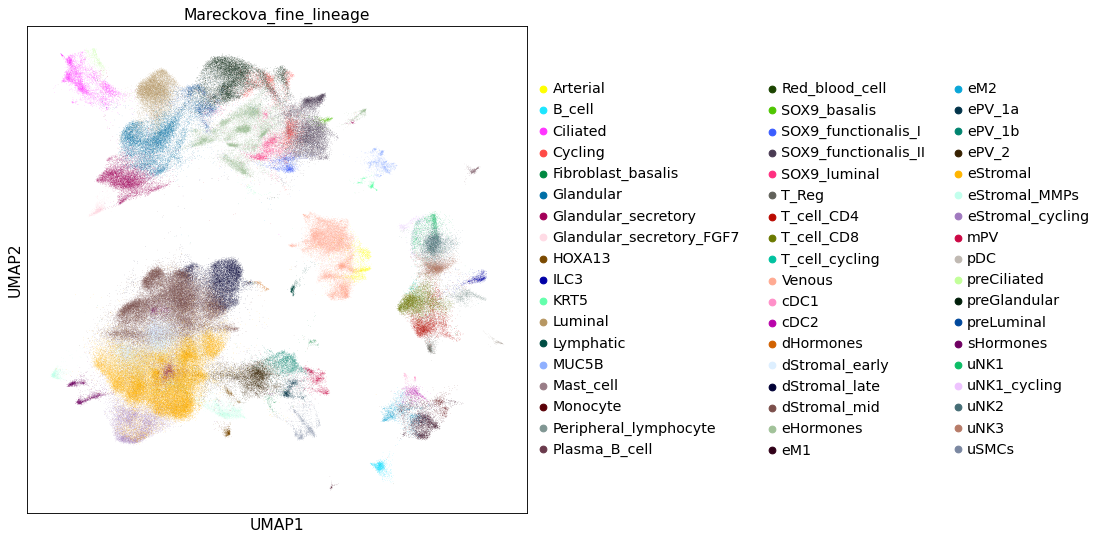

In [13]:
adata = adata[[ i not in ['Doublet', 'LowQC', 'Other'] for i in adata.obs['Mareckova_fine_lineage'] ]]
adata = adata[[ 'Epi_' not in i for i in adata.obs['Mareckova_fine_lineage'] ]]
adata = adata[[ 'Mesen_' not in i for i in adata.obs['Mareckova_fine_lineage'] ]]
adata = adata[[ 'Immune_' not in i for i in adata.obs['Mareckova_fine_lineage'] ]]
sc.pl.umap(adata, color=['Mareckova_fine_lineage'])

In [14]:
## Remove cycling populations
adata = adata[[ 'G1' in i for i in adata.obs.phase]]
adata = adata[[ 'Cycling' not in i for i in adata.obs.Mareckova_fine_lineage]]
adata = adata[[ 'cycling' not in i for i in adata.obs.Mareckova_fine_lineage]]
adata = adata[[ 'Hormones' not in i for i in adata.obs.Mareckova_fine_lineage]]
adata = adata[[ 'Red_blood_cell' not in i for i in adata.obs.Mareckova_fine_lineage]]
print(adata.obs['Mareckova_fine_lineage'].value_counts())
# print(adata.obs['Mareckova_fine_celltype'].value_counts())

eStromal                    54645
dStromal_mid                43445
dStromal_early              16751
Venous                      14375
Glandular                   12827
SOX9_functionalis_II        12261
dStromal_late               12032
preGlandular                11663
Luminal                     10129
Glandular_secretory          8439
ePV_2                        6648
T_cell_CD8                   5370
uNK2                         4284
T_cell_CD4                   4132
eStromal_MMPs                3987
Ciliated                     3942
eM1                          3760
uNK3                         3469
preLuminal                   2655
ePV_1b                       2411
SOX9_luminal                 2210
Arterial                     1641
SOX9_functionalis_I          1569
eM2                          1524
ePV_1a                       1375
uSMCs                        1367
MUC5B                        1365
mPV                          1352
uNK1                         1332
B_cell        

### Select cells with > 2000 genes expressed

In [15]:
sc.pp.filter_cells(adata, min_genes=2000)
print(adata.obs['Mareckova_fine_lineage'].value_counts())

Trying to set attribute `.obs` of view, copying.


eStromal                    46625
dStromal_mid                30721
dStromal_early              14242
preGlandular                11205
SOX9_functionalis_II        11112
Glandular                    9939
Venous                       9784
Glandular_secretory          7322
dStromal_late                6970
Luminal                      6369
ePV_2                        5626
eStromal_MMPs                3799
Ciliated                     3459
eM1                          2591
preLuminal                   2515
SOX9_luminal                 2184
ePV_1b                       2015
SOX9_functionalis_I          1543
MUC5B                        1245
Arterial                     1107
ePV_1a                        932
eM2                           909
uNK1                          768
HOXA13                        645
mPV                           641
uNK2                          612
uSMCs                         544
cDC2                          541
KRT5                          434
uNK3          

### Use Ensembl id as GENE 

In [16]:
adata.var['SYMBOL'] = adata.var_names
adata.var.rename(columns={'gene_ids-0-GarciaAlonso': 'ENSEMBL'}, inplace=True)
adata.var_names = adata.var['ENSEMBL']
adata.var.drop(columns='ENSEMBL', inplace=True)

In [17]:
adata.var_names = adata.var_names.astype(str)
adata.var_names_make_unique()

In [18]:
adata.write(path + '/cell2location/scRNAseq_withimmune.h5ad')